# Atari
ALE/SpaceInvaders-v5

## Import Libraries

In [1]:
#https://gymnasium.farama.org/environments/atari/
#pip install gymnasium[atari]
#pip install gymnasium[accept-rom-license]
#pip install moviepy
#https://www.youtube.com/watch?v=hCeJeq8U0lo&t=447s

import gymnasium as gym

#image preprocessing
from PIL import Image
from gymnasium.core import ObservationWrapper
from gymnasium.spaces.box import Box
import numpy as np
import matplotlib.pyplot as plt

#n-step experience replay
from collections import namedtuple, deque

#deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from gymnasium.wrappers import RecordVideo #enviornment monitoring
import random

from sklearn.model_selection import train_test_split #for splitting memory into training and testing
import pandas as pd

import shap
import math
import datetime

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
from statsmodels.formula.api import ols

d:\Projects\repos\tu060\venv_research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Deep Convelutional Q-Learning Agent

In [2]:
### Convelutional Neural Network
class CNN(nn.Module):
    def __init__(self, number_actions):
        super(CNN, self).__init__() # call nn module init
        #define what each layer in CNN is
        self.convolution1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)

        #pass image through convolution layers and get neurons in a flatten layer to pass into a neural network
        self.fc1 = nn.Linear(in_features=self.count_neurons((1, 80, 80)), out_features=40) #1 is number of channels so black and white images, 80 80 is width and height
        self.fc2 = nn.Linear(in_features=40, out_features=number_actions)

    def count_neurons(self, image_dim):#image_dim for example 80px x 80px in size
        """Will give us the number of neurons after convolutions are applied"""
        #we need to first create a fake image (1 batch, 80px x 80px in size), * allows image_dim to be passed as a list
        fake_image = Variable(torch.rand(1, *image_dim))

        #pass image into first layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution1(fake_image), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into second layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2)) #kernal size is 3, #stride is 2

        #pass image into third layer and max pool result then activate all neurons in max pool layer
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2)) #kernal size is 3, #stride is 2
        
        #now we get all pixels in third layer and flatten it. we get the data, view what's inside it then we get all the pixels and put it into 1 dimension
        return x.data.view(1, -1).size(1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        #propagate data from convolutional layers to hidden layers by first flattening convolutional layers
        #flatten third layer by taking all pixels and all channels in third layer and arrange one after another
        x = x.view(x.size(0), -1) #RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x49 and 3136x40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Softmax Policy
class SoftmaxPolicy(nn.Module):
    """data from the CNN is passed to softmax to play an action"""
    def __init__(self, T=100):
        super(SoftmaxPolicy, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T, dim=1)
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Agent (DCQ Learning System )
class DCQ():
    def __init__(self, CNN, SoftmaxPolicy):
        self.cnn = CNN
        self.softmax = SoftmaxPolicy

    def __call__(self, inputs):#comes from NStepProgress -> np.array([state])
        """similar to init function but it allows this AI class 
        instance to be treated like a function, not modifying the initial instance"""
        #receive images from the game by converting image into a numpy array then into a torch tensor, then put a torch tensor into a torch variable with a gradient
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.cnn(input)
        actions = self.softmax(output)
        return actions.data.numpy()

### Experience Replay
#### N-Step
class NStepProgress:
    """This class allows the AI to progress on several (n_step) steps"""
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
        self.step = namedtuple('Step', ['state', 'action', 'reward', 'done']) #Defining one Step
    def __iter__(self):
        observation, info = self.env.reset()
        history = deque()
        score = 0.0
        while True:
            #select an action
            action = self.ai(np.array([observation]))[0][0] #agent.update
            #get reward and next state
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            score += reward
            #add to stacked frame
            history.append(self.step(state=observation, action=action, reward=score, done=done))
            while len(history) > self.n_step + 1:
                history.popleft()
            if len(history) == self.n_step + 1:#create our stacked tuple when finished
                yield tuple(history)
            if done:
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(score)
                score = 0.0
                observation, info  = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

#### Replay Memory
class ReplayMemory:
    """This class is modified to do n-step learning"""
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps)
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0 #we use an offset to keep track of starting index for each batch
        #we get samples from experience replay
        vals = list(self.buffer)
        #then randomly suffle them
        np.random.shuffle(vals)
        #now we check to see if we have enough samples in the buffer to make a batch if not we wait.
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size] #we slice from the offset position to the e.g 128 to 256
            ofs += 1

    def run_steps(self, samples):
        """Runs environment for 10 consecutive steps and"""
        while samples > 0:
            entry = next(self.n_steps_iter) # 10 consecutive steps of (state, action, reward, done)
            self.buffer.append(entry) # we put 200 for the current episode
            samples -= 1
        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (10000)
            self.buffer.popleft()
            
### N-Step Q-Learning
def eligibility_trace(batch, cnn, g=0.99):#batch is a sample of 128 10-steps where each step is ['state', 'action', 'reward', 'done'] so 1,280 transitions from memory
    """Asynchronous N-Step Q-Learning
    learns the cumulative rewards and cumulative targets
    on n-steps instead of one step like DQL"""
    gamma = g
    inputs = []
    targets = []
    for series in batch: #series of 10 transitions in our batch
        #get the first and last image as the input. Convert fron numpy to torch variable
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype=np.float32)))
        output = cnn(input) #this is the prediction from the ai

        #if the last transition of the series is not done we get the max q values
        cumulative_reward = 0.0 if series[-1].done else output[1].data.max()

        #start with the last step and go backwards to the first step
        for step in reversed(series[:-1]):#reversed goes backwards 
            state = series[0].state # first state we need. This is where we started
            target = output[0].data # this is the q value of the input state of the first step. This is what we thought we would get being in this state

            # what new reward did we actually get
            cumulative_reward = step.reward + gamma * cumulative_reward 
            target[series[0].action] = cumulative_reward # this is the q value we actually got

            inputs.append(state) # we append our first state
            targets.append(target) #we append the actual target q value for the first state

            #output the input and the target after being processed through eligibility_trace
            #we now have the first state and the target q values for the first state over 10 steps
            return torch.from_numpy(np.array(inputs, dtype=np.float32)), torch.stack(targets)#we stack targets together

### Image Preprocessing
class ImagePreprocessor(ObservationWrapper):
    """Custom Image Preprocessor similar to 
    Atari standard in gymnasium"""
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(ImagePreprocessor, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = Image.fromarray(img)
        img = img.resize(self.img_size)
        if self.grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB if necessary

        #view preprocessed image
        #plt.imshow(img)
        #plt.show()

        img = np.array(img)
        #adds a new dimension to the array to represent the single color channel, resulting in the desired shape
        img = np.expand_dims(img, axis=2)
        
        #if img.ndim == 2:  # Add channel dimension if missing
        #    img = np.expand_dims(img, axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255

        #check dim of new image
        #print("image was preprocessed to: " + str("greyscale" if self.grayscale else "RGB") + " with shape " + str(img.shape))
        return img

### Moving Average Reward (for evaluation)
class MA:
    """creates the moving average reward on 
    100 steps to keep track of training performance"""
    def __init__(self, size):
        self.list_of_rewards = []
        self.average_rewards = []
        self.max_reward = 0
        self.cumulative_rewards = []
        self.size = size
    def add(self, rewards):
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0] # makes sure that we always have 100 elements of the latest rewards

        #get the latest high score if one exists
        if(len(self.list_of_rewards)>0):
            max_score = max(self.list_of_rewards)
            if max_score > self.max_reward:
                self.max_reward = max_score
            
        #collect score over time
        self.cumulative_rewards.append(sum(self.list_of_rewards))
    def average(self):
        if len(self.list_of_rewards) > 0:
            average_reward = np.mean(self.list_of_rewards)
            self.average_rewards.append(average_reward)
            return average_reward
        else:
            return 0.0  # or any other appropriate default value

## Experiments

### Experience Replay Capacity Sizes

In [3]:
capacity = [1000000, 500000, 100000, 50000, 10000, 5000, 1000, 500]
labels = ['1M', '500k', '100k', '50k', '10k', '5k', '1k', '500']

#create table for evaluating capacity against reward
df_rewards = pd.DataFrame(columns=['capacity', 'episodes', 'reward'])

### Simulation

EXPERIMENT 0: Capacity: 1M
Setting up environment
Creating Agent with capacity set to: 1000000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 105.0
Epoch: 3, Average Reward: 105.0
Epoch: 4, Average Reward: 105.0
Epoch: 5, Average Reward: 257.5
Epoch: 6, Average Reward: 257.5
Epoch: 7, Average Reward: 257.5
Epoch: 8, Average Reward: 190.0
Epoch: 9, Average Reward: 190.0
Epoch: 10, Average Reward: 190.0
Epoch: 11, Average Reward: 190.0
Epoch: 12, Average Reward: 161.25
Epoch: 13, Average Reward: 161.25
Epoch: 14, Average Reward: 161.25
Epoch: 15, Average Reward: 161.25
Epoch: 16, Average Reward: 161.25
Epoch: 17, Average Reward: 165.0
Epoch: 18, Average Reward: 165.0
Epoch: 19, Average Reward: 165.0
Epoch: 20, Average Reward: 165.0
Epoch: 21, Average Reward: 165.0
Epoch: 22, Average Reward: 178.33
Epoch: 23, Average Reward: 178.33
Epoch: 24, Average Reward: 170.0
Epoch: 25, Average Reward: 170.0
Epoch: 26, Average Reward: 170.

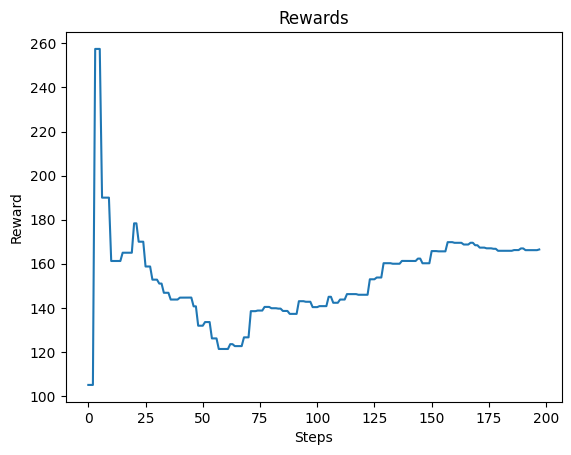

END
EXPERIMENT 1: Capacity: 500k
Setting up environment
Creating Agent with capacity set to: 500000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 0.0
Epoch: 5, Average Reward: 660.0
Epoch: 6, Average Reward: 660.0
Epoch: 7, Average Reward: 660.0
Epoch: 8, Average Reward: 435.0
Epoch: 9, Average Reward: 435.0
Epoch: 10, Average Reward: 435.0
Epoch: 11, Average Reward: 435.0
Epoch: 12, Average Reward: 385.0
Epoch: 13, Average Reward: 385.0
Epoch: 14, Average Reward: 385.0
Epoch: 15, Average Reward: 315.0
Epoch: 16, Average Reward: 315.0
Epoch: 17, Average Reward: 315.0
Epoch: 18, Average Reward: 283.0
Epoch: 19, Average Reward: 283.0
Epoch: 20, Average Reward: 283.0
Epoch: 21, Average Reward: 235.83
Epoch: 22, Average Reward: 235.83
Epoch: 23, Average Reward: 235.83
Epoch: 24, Average Reward: 242.86
Epoch: 25, Average Reward: 242.86
Epoch: 26, Average Reward: 242.86


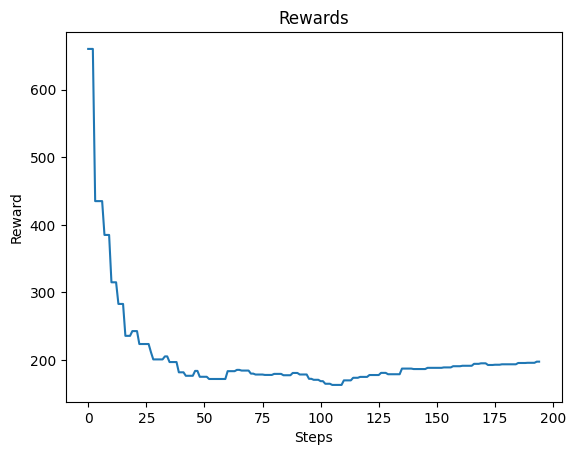

END
EXPERIMENT 2: Capacity: 100k
Setting up environment
Creating Agent with capacity set to: 100000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 120.0
Epoch: 3, Average Reward: 120.0
Epoch: 4, Average Reward: 120.0
Epoch: 5, Average Reward: 192.5
Epoch: 6, Average Reward: 192.5
Epoch: 7, Average Reward: 151.67
Epoch: 8, Average Reward: 151.67
Epoch: 9, Average Reward: 113.75
Epoch: 10, Average Reward: 113.75
Epoch: 11, Average Reward: 113.75
Epoch: 12, Average Reward: 113.75
Epoch: 13, Average Reward: 113.75
Epoch: 14, Average Reward: 113.75
Epoch: 15, Average Reward: 113.75
Epoch: 16, Average Reward: 234.0
Epoch: 17, Average Reward: 234.0
Epoch: 18, Average Reward: 234.0
Epoch: 19, Average Reward: 234.0
Epoch: 20, Average Reward: 234.0
Epoch: 21, Average Reward: 255.83
Epoch: 22, Average Reward: 255.83
Epoch: 23, Average Reward: 255.83
Epoch: 24, Average Reward: 255.83
Epoch: 25, Average Reward: 263.57
Epoch: 26, Average 

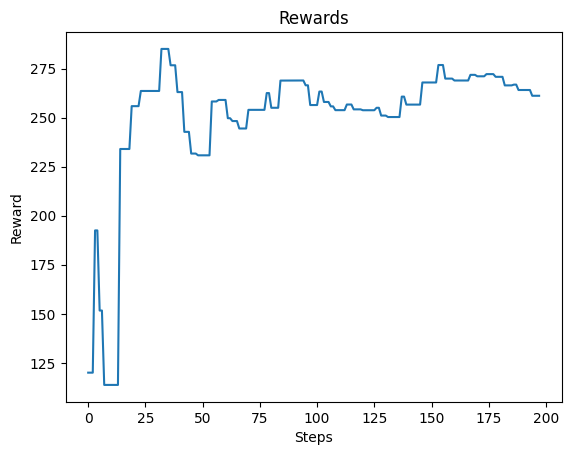

END
EXPERIMENT 3: Capacity: 50k
Setting up environment
Creating Agent with capacity set to: 50000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 20.0
Epoch: 2, Average Reward: 20.0
Epoch: 3, Average Reward: 60.0
Epoch: 4, Average Reward: 60.0
Epoch: 5, Average Reward: 60.0
Epoch: 6, Average Reward: 91.67
Epoch: 7, Average Reward: 91.67
Epoch: 8, Average Reward: 68.75
Epoch: 9, Average Reward: 68.75
Epoch: 10, Average Reward: 68.75
Epoch: 11, Average Reward: 68.75
Epoch: 12, Average Reward: 73.0
Epoch: 13, Average Reward: 73.0
Epoch: 14, Average Reward: 73.0
Epoch: 15, Average Reward: 108.33
Epoch: 16, Average Reward: 108.33
Epoch: 17, Average Reward: 108.33
Epoch: 18, Average Reward: 108.33
Epoch: 19, Average Reward: 133.57
Epoch: 20, Average Reward: 133.57
Epoch: 21, Average Reward: 133.57
Epoch: 22, Average Reward: 120.62
Epoch: 23, Average Reward: 120.62
Epoch: 24, Average Reward: 120.62
Epoch: 25, Average Reward: 131.67
Epoch: 26, Average Reward: 131

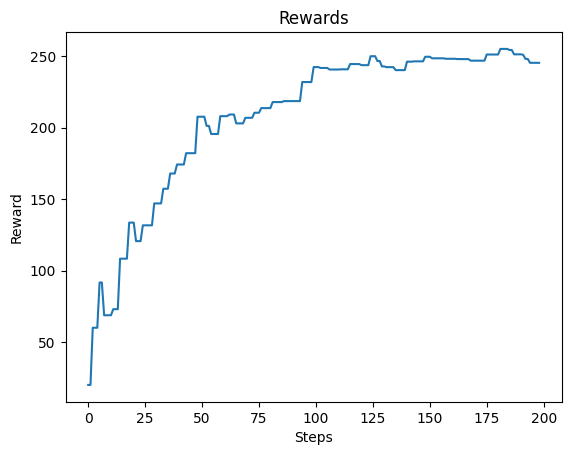

END
EXPERIMENT 4: Capacity: 10k
Setting up environment
Creating Agent with capacity set to: 10000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 210.0
Epoch: 4, Average Reward: 210.0
Epoch: 5, Average Reward: 157.5
Epoch: 6, Average Reward: 157.5
Epoch: 7, Average Reward: 157.5
Epoch: 8, Average Reward: 155.0
Epoch: 9, Average Reward: 155.0
Epoch: 10, Average Reward: 130.0
Epoch: 11, Average Reward: 130.0
Epoch: 12, Average Reward: 130.0
Epoch: 13, Average Reward: 118.0
Epoch: 14, Average Reward: 118.0
Epoch: 15, Average Reward: 118.0
Epoch: 16, Average Reward: 118.0
Epoch: 17, Average Reward: 115.83
Epoch: 18, Average Reward: 115.83
Epoch: 19, Average Reward: 117.14
Epoch: 20, Average Reward: 117.14
Epoch: 21, Average Reward: 117.14
Epoch: 22, Average Reward: 136.25
Epoch: 23, Average Reward: 136.25
Epoch: 24, Average Reward: 136.25
Epoch: 25, Average Reward: 135.56
Epoch: 26, Average Reward: 1

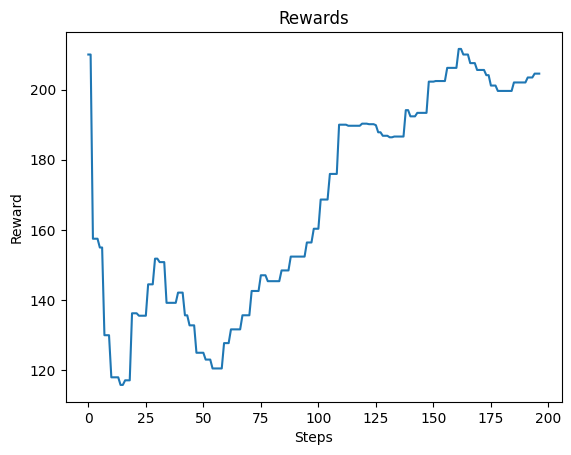

END
EXPERIMENT 5: Capacity: 5k
Setting up environment
Creating Agent with capacity set to: 5000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 265.0
Epoch: 4, Average Reward: 265.0
Epoch: 5, Average Reward: 265.0
Epoch: 6, Average Reward: 265.0
Epoch: 7, Average Reward: 267.5
Epoch: 8, Average Reward: 267.5
Epoch: 9, Average Reward: 267.5
Epoch: 10, Average Reward: 267.5
Epoch: 11, Average Reward: 273.33
Epoch: 12, Average Reward: 273.33
Epoch: 13, Average Reward: 273.33
Epoch: 14, Average Reward: 276.25
Epoch: 15, Average Reward: 276.25
Epoch: 16, Average Reward: 276.25
Epoch: 17, Average Reward: 242.0
Epoch: 18, Average Reward: 242.0
Epoch: 19, Average Reward: 242.0
Epoch: 20, Average Reward: 248.33
Epoch: 21, Average Reward: 248.33
Epoch: 22, Average Reward: 248.33
Epoch: 23, Average Reward: 232.86
Epoch: 24, Average Reward: 232.86
Epoch: 25, Average Reward: 203.75
Epoch: 26, Average Reward: 

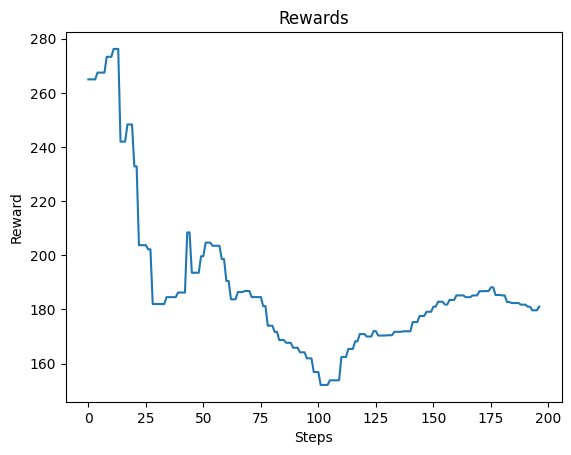

END
EXPERIMENT 6: Capacity: 1k
Setting up environment
Creating Agent with capacity set to: 1000
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 0.0
Epoch: 3, Average Reward: 0.0
Epoch: 4, Average Reward: 670.0
Epoch: 5, Average Reward: 670.0
Epoch: 6, Average Reward: 670.0
Epoch: 7, Average Reward: 380.0
Epoch: 8, Average Reward: 380.0
Epoch: 9, Average Reward: 380.0
Epoch: 10, Average Reward: 380.0
Epoch: 11, Average Reward: 315.0
Epoch: 12, Average Reward: 315.0
Epoch: 13, Average Reward: 303.75
Epoch: 14, Average Reward: 303.75
Epoch: 15, Average Reward: 303.75
Epoch: 16, Average Reward: 297.0
Epoch: 17, Average Reward: 297.0
Epoch: 18, Average Reward: 297.0
Epoch: 19, Average Reward: 292.5
Epoch: 20, Average Reward: 292.5
Epoch: 21, Average Reward: 292.5
Epoch: 22, Average Reward: 289.29
Epoch: 23, Average Reward: 289.29
Epoch: 24, Average Reward: 286.88
Epoch: 25, Average Reward: 286.88
Epoch: 26, Average Reward: 286.88


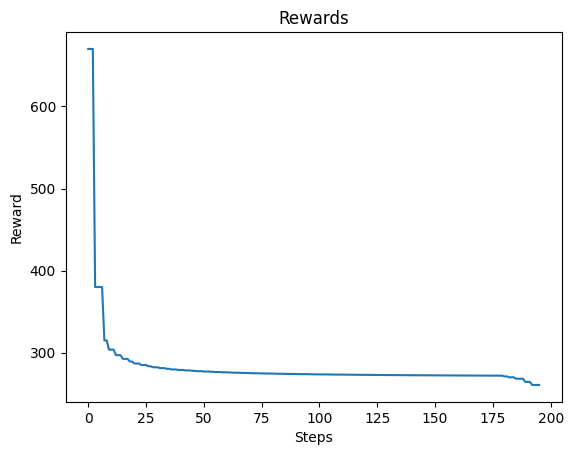

END
EXPERIMENT 7: Capacity: 500
Setting up environment
Creating Agent with capacity set to: 500
Simulating environment
Epoch: 0, Average Reward: 0.0
Epoch: 1, Average Reward: 0.0
Epoch: 2, Average Reward: 210.0
Epoch: 3, Average Reward: 210.0
Epoch: 4, Average Reward: 210.0
Epoch: 5, Average Reward: 210.0
Epoch: 6, Average Reward: 275.0
Epoch: 7, Average Reward: 275.0
Epoch: 8, Average Reward: 275.0
Epoch: 9, Average Reward: 275.0
Epoch: 10, Average Reward: 275.0
Epoch: 11, Average Reward: 273.33
Epoch: 12, Average Reward: 273.33
Epoch: 13, Average Reward: 273.33
Epoch: 14, Average Reward: 276.25
Epoch: 15, Average Reward: 276.25
Epoch: 16, Average Reward: 276.25
Epoch: 17, Average Reward: 276.25
Epoch: 18, Average Reward: 278.0
Epoch: 19, Average Reward: 278.0
Epoch: 20, Average Reward: 278.0
Epoch: 21, Average Reward: 278.0
Epoch: 22, Average Reward: 279.17
Epoch: 23, Average Reward: 279.17
Epoch: 24, Average Reward: 279.17
Epoch: 25, Average Reward: 280.0
Epoch: 26, Average Reward: 

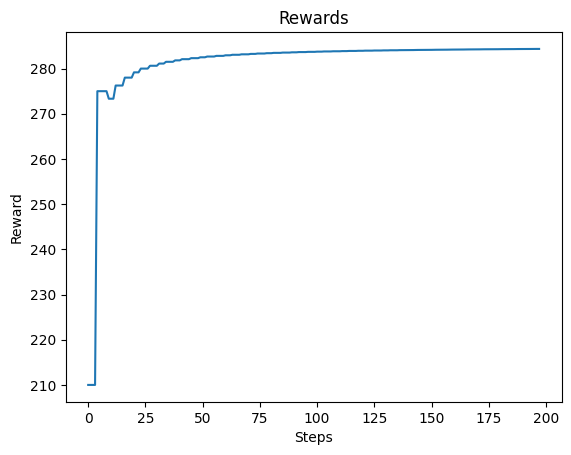

END


In [4]:
for i, cap in enumerate(capacity):
    print("EXPERIMENT " + str(i) + ": Capacity: " + str(labels[i]))
    #### Setup Preprocessed Environment
    print("Setting up environment")
    #env = gym.make('ALE/SpaceInvaders-v5')
    #We first preprocess the image by applying a greyscale and reducing the size to 80px. 
    env = ImagePreprocessor(gym.make('ALE/SpaceInvaders-v5'), width=80, height=80, grayscale=True) #width=210, height=160 # , render_mode='human'
    observation, info = env.reset(seed=42)
    
    ##### Create DCQL Agent
    print("Creating Agent with capacity set to: " + str(cap))
    a = env.action_space.n # actions
    g = 0.9 #gamma
    c = cap #1000000 #10000 #memory capacity
    m = 128 #memory sampling
    l = 0.001 #learning rate
    t = 1.0 #softmax policy temperature rate

    #Build the agent
    cnn = CNN(a)
    softmax = SoftmaxPolicy(T=t) # T is temperature high means other actions are less explored
    agent = DCQ(CNN=cnn, SoftmaxPolicy=softmax)

    # Set up Experience Replay
    n_steps = NStepProgress(env=env, ai=agent, n_step=10) #instead of learning every transition we learn every nth transition
    memory = ReplayMemory(n_steps=n_steps, capacity=c) #last ten thousand steps

    #set learning parameters
    loss = nn.MSELoss()#calculate mean squared error loss
    optimizer = optim.Adam(cnn.parameters(), lr=l) #use adams optimiser with a learning rate of 0.001

    ma = MA(100)#get the average of the last 100 rewards

    #### Simulate the environment
    print("Simulating environment")
    episodes = 200 #200

    # Initialize an empty list to store the sampled inputs for SHAP Explainer
    # set a sampling rate based on episodes as batches could be zero if not enough available at start

    #define a random selection size such as 10%
    random_select_size = math.ceil(episodes * 0.1) # 10%

    # Create an array of random episode numbers
    random_episodes = np.random.choice(range(episodes), size=random_select_size, replace=False)

    # Initialize an empty list to store the sampled inputs for SHAP Explainer
    sampling_episode = []
    sampled_inputs = []
    sampled_targets = []
    episode_sampled = False  # Initialize the flag

    for episode in range(episodes):
        #run the game for 200 runs of 10 steps and push sample transitions into memory
        memory.run_steps(samples=200)
        #sample 128 x10['state', 'action', 'reward', 'done'] or 1,280 transitions from memory if there is enough in memory to sample otherwise skip
        for batch in memory.sample_batch(m): #m=128
            #agent training
            #we get target discounted q values for the first state in the batch over 10 steps
            inputs, targets = eligibility_trace(batch, cnn, g)

            #We take some samples for shap.deepxplainer to create heatmap images or we use them for training. Not both!
            if episode in random_episodes and not episode_sampled:
                sampling_episode.append(episode) #record when sample was taken
                sampled_inputs.append(inputs)
                sampled_targets.append(targets)
                episode_sampled = True # Set the flag to True
            else:
                #we convert them to tensor variables
                inputs, targets = Variable(inputs), Variable(targets)

                #like during eligibility_trace we get predicted q values from the cnn model
                predictions = cnn(inputs)
                loss_error = loss(predictions, targets)
                optimizer.zero_grad()
                loss_error.backward()
                optimizer.step()
        
        episode_sampled = False # Reset the flag for the next iteration
                
        rewards_steps = n_steps.rewards_steps()
        ma.add(rewards_steps)
        avg_reward = ma.average()
        print("Epoch: %s, Average Reward: %s" % (str(episode), str(round(avg_reward,2))))
    env.close()

    #### Save Trained Model
    #torch.save(cnn, './../models/space_invaders.pth')
    #### Load Trained Model
    #cnn = torch.load('./../models/space_invaders.pth')
    #cnn.eval()

    #### HOW did the agent performed?
    print("printing results")
    ##### Agent's final score
    print(ma.max_reward) #595.0 # Current sum of all values in the reward window
    ##### Rewards at given time/step
    # Iterate over the rows of average_rewards and append them to df_rewards
    for episode, reward in enumerate(ma.average_rewards):
        new_row = [labels[i], episode, reward]
        df_rewards.loc[len(df_rewards)] = new_row
        
    # Save and plot reward
    plt.title("Rewards")
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.plot(ma.average_rewards)
    plt.show()
    print("END")

#### WHY does the agent take an actions in the given state?

In [5]:
#we took 10% of experience replay samples as test data. The agent has not seen this yet
print(random_episodes)
len(sampled_inputs)

[ 45 150  12 139 128 160 123 127 117  46  61  13 162 149  69 155  90 104
  81  93]


20

In [6]:
x = sampling_episode
print(x)

[12, 13, 45, 46, 61, 69, 81, 90, 93, 104, 117, 123, 127, 128, 139, 149, 150, 155, 160, 162]


In [7]:
#After halfway through its training lets see why the agent took the actions it did
s = math.ceil(len(x)/2)
print(s)

10


In [8]:
# The first sample is a tensor of pixels indicating an image
sampled_inputs[s]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098],
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098],
          [0.3098, 0.3098, 0.3098,  ..., 0.3098, 0.3098, 0.3098]]]])

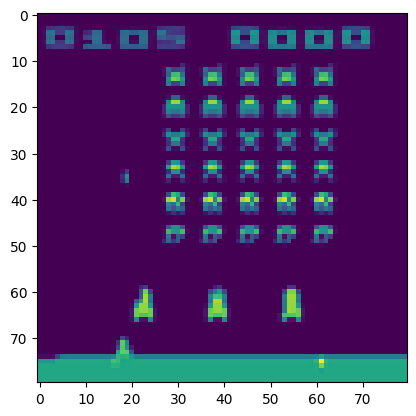

In [9]:
# we can see what that image is
plt.imshow(sampled_inputs[s].view(80, 80, 1))
plt.show()

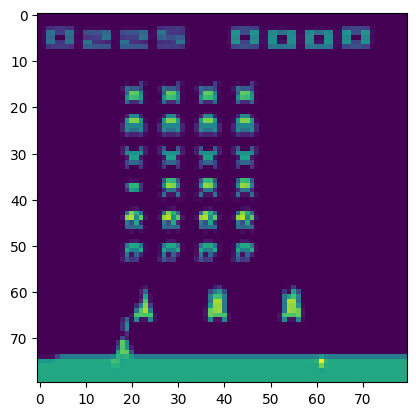

In [10]:
# we then see what the next image is
plt.imshow(sampled_inputs[s+1].view(80, 80, 1))
plt.show()

In [11]:
# we see what Q values were calculated for each action for first image
sampled_targets[s]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[-182.4031, 1203.6371,  351.1270,  203.7461,  376.2118,   -4.5531]])

In [12]:
# we see what Q values were calculated for each action for second image
sampled_targets[s+1]
#['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

tensor([[-141.7252, 1191.9524,  307.8025,  178.7625,  329.8098,   -4.8317]])

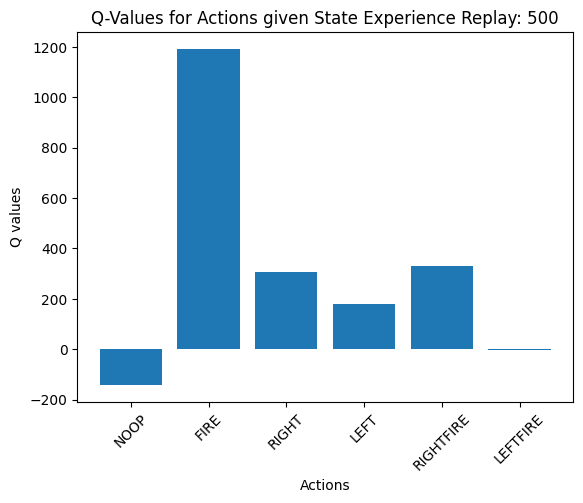

In [13]:
# Set the x-axis values
x = env.unwrapped.get_action_meanings()

# Set the y-axis values
y = np.array(sampled_targets[s+1])[0]

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the bar chart
ax.bar(x, y)

# Set the labels and title
ax.set_xlabel('Actions')
ax.set_ylabel('Q values')
ax.set_title('Q-Values for Actions given State Experience Replay: ' + str(c))

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the bar chart
plt.show()

In [14]:
background = sampled_inputs[s] #we use the first image for shap explainer
test_image = sampled_inputs[s+1] #we use the second image for testing shap explainer

In [15]:
e = shap.DeepExplainer(cnn, background) # train shap explainer
 # we approximate the conditional expectations of SHAP values using a selection of background samples.
 # By integrating over many backgound samples Deep estimates approximate SHAP values such that 
 # they sum up to the difference between the expected model output on the passed 
 # background samples and the current model output (f(x) - E[f(x)]).

In [16]:
shap_values = e.shap_values(test_image) #get shap values for second image

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [17]:
shap_values

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]),
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

In [18]:
shap_values = torch.from_numpy(np.array(shap_values, dtype=np.float32)) #convert shap values into a tensor

In [19]:
shap_values.shape #this tensor has 6 samples, each having 1 channel, a height of 1, a width of 80, and a depth of 80.

torch.Size([6, 1, 1, 80, 80])

In [20]:
shap_values[0].shape # shap_value sample is an image

torch.Size([1, 1, 80, 80])

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


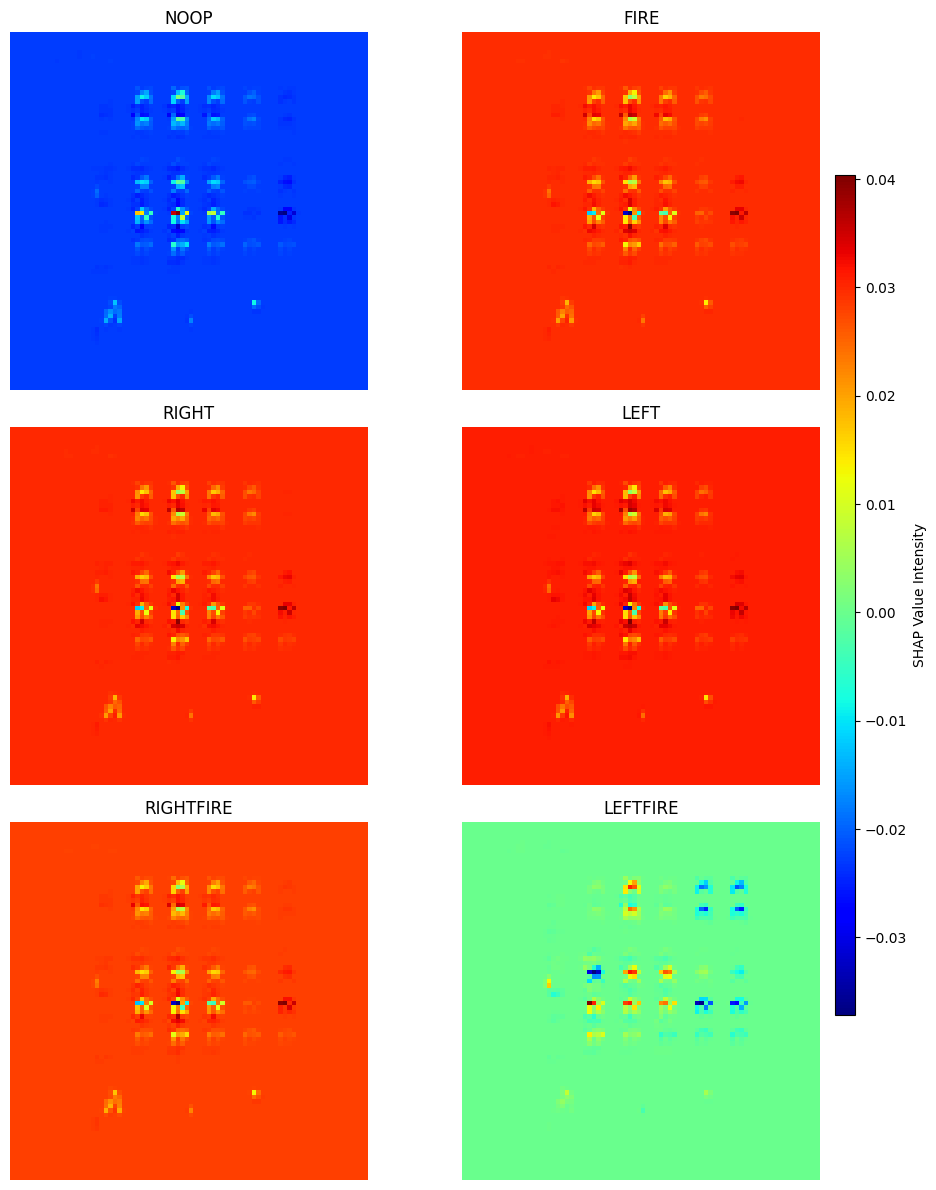

In [21]:
#plt.imshow(shap_values[0].view(80, 80, 1))
#plt.show() # image shows the importance of each action

#plt.imshow(sampled_inputs[s+1].view(80, 80, 1), cmap='gray') 
#plt.imshow(shap_values[0].view(80, 80, 1)) #0=NOOP
#plt.imshow(shap_values[1].view(80, 80, 1)) #1=FIRE
#plt.imshow(shap_values[2].view(80, 80, 1) ) #2=RIGHT
#plt.imshow(shap_values[3].view(80, 80, 1), cmap='hot', alpha=0.1) #3=LEFT
#plt.imshow(shap_values[4].view(80, 80, 1), cmap='hot', alpha=0.1) #4=RIGHTFIRE
#plt.imshow(shap_values[5].view(80, 80, 1), cmap='hot', alpha=0.1) #5=LEFTFIRE

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# List of action labels
action_labels = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

# Loop through the actions and their corresponding SHAP values
for i, ax in enumerate(axes.flatten()):
    shap_value = shap_values[i].view(80, 80, 1)
    im = ax.imshow(shap_value, cmap='jet')  # Use 'jet' colormap or your preferred colormap
    ax.set_title(action_labels[i])
    ax.axis('off')

# Create a colorbar legend on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label('SHAP Value Intensity')

# Adjust layout to prevent overlap of subplots and colorbar
plt.tight_layout()

# Show the plot
plt.show()

# This code creates a 3x2 grid of subplots, displaying each action's SHAP 
# values in a separate subplot. It adds titles to the subplots corresponding 
# to the action labels. The colorbar is created on the right using the add_axes 
# function, and tight_layout is used to ensure that the subplots and colorbar 
# are arranged nicely within the figure. Adjust the figsize and other parameters 
# as needed to achieve the desired appearance of the plot.

## ANOVA

In [22]:
df_rewards.tail()

,capacity,episodes,reward
1573,500,193,284.339623
1574,500,194,284.351852
1575,500,195,284.351852
1576,500,196,284.351852
1577,500,197,284.351852


In [23]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + "_atari_space_invaders_shap" + ".csv"
df_rewards.to_csv(file_name, index=False, encoding='utf-8')

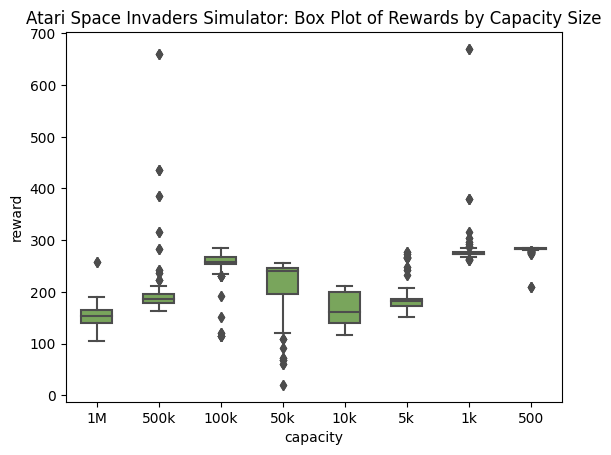

In [24]:
ax = sns.boxplot(x='capacity', y='reward', data=df_rewards, color='#77B150', width=0.5).set(title='Atari Space Invaders Simulator: Box Plot of Rewards by Capacity Size')
plt.show()